In [21]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
from scipy.stats import ttest_rel, ttest_ind
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

from p_body_randomness.extract_sample_areas import extract_sample_area
from p_body_randomness.sampling import sample_pbodies
from p_body_randomness.centroids import extract_centroids
from p_body_randomness.metrics import nearest_neighbor_distance
from p_body_randomness.smooth_image import smooth_protein_image

%matplotlib inline

In [11]:
# in the example data x is in [0,5], y=0, z=0
# we choose a set of 10 images to demonstrate our functions


TEMPLATE_PATH = '../data/input_data/20180606-SLP_Multiplexing_p1_C03_x00{x}_y000_z000_t000_{image_type}_Label{label}.png'
NUM_IMAGES = 2
MIN_CENTROIDS = 5

image_types = {'pbodies': '13_Pbody_Segm', 'protein': '13_Succs', 'cellmask': 'segmentation', 'dapi': '2_DAPI'}

random.seed(42)

images = []
while len(images) < NUM_IMAGES:
    candidate = {'x': random.randint(0, 5), 'label': random.randint(0, 40)}
    if Path(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies'])).is_file():
        if len(extract_centroids(cv2.imread(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies']), 0))) >= MIN_CENTROIDS:
            images.append(candidate)
    


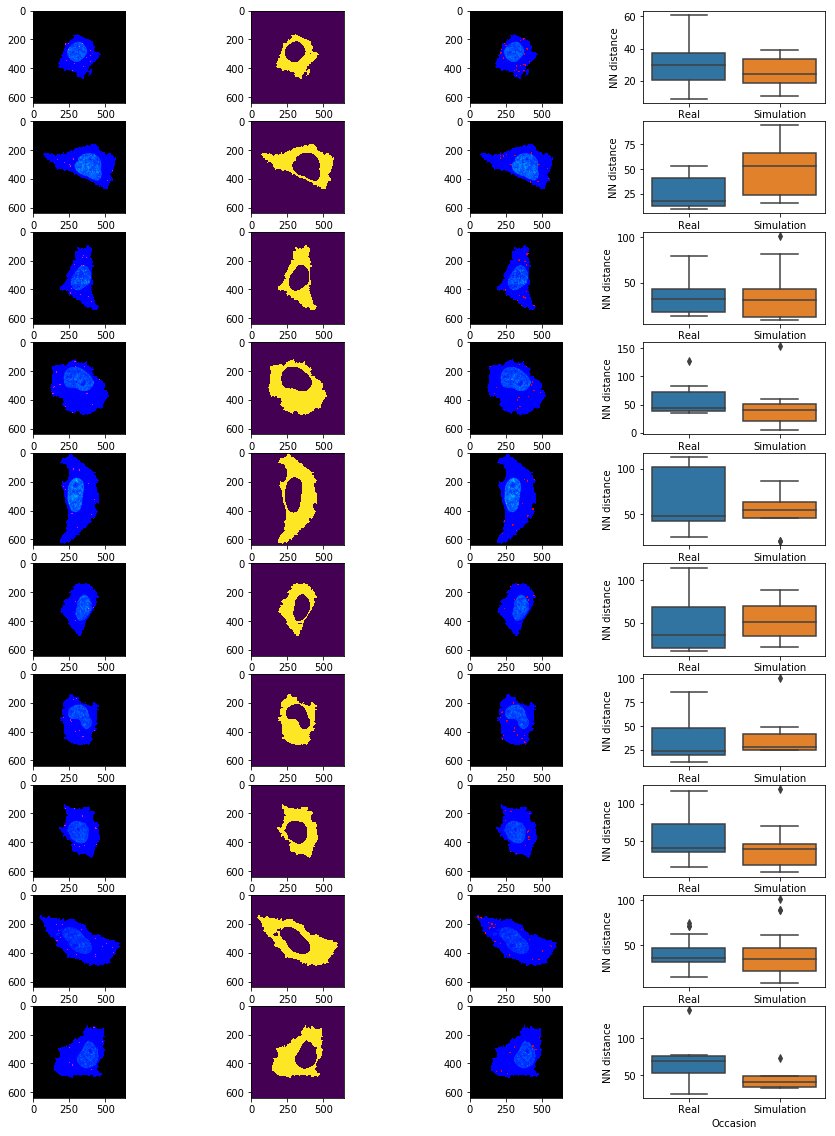

In [69]:
fig, axes = plt.subplots(ncols=4, nrows=NUM_IMAGES, figsize=(15, 20))

real_distances = []
simulated_distances = []

for i in range(NUM_IMAGES):
    # read raw channels
    pbodies_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['pbodies']), 0)
    dapi_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['dapi']), 0)
    cellmask_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['cellmask']), 0)
    
    # plot the available channels
    full_image = np.zeros((*pbodies_image.shape, 3), dtype=np.uint8)
    full_image[:, :, 0] = pbodies_image
    full_image[:, :, 1] = dapi_image
    full_image[:, :, 2] = cellmask_image
    axes[i, 0].imshow(full_image)
    
    centroids = extract_centroids(pbodies_image)
    # plot the sample area
    cytoplasmic_mask = extract_sample_area(cellmask_image, dapi_image)
    axes[i, 1].imshow(cytoplasmic_mask)

    # plot the sampled pbodies
    sampled_pbodies = sample_pbodies(cytoplasmic_mask, len(centroids), area_fn=lambda: 100)
    
    sampled_image = np.zeros((*pbodies_image.shape, 3), dtype=np.uint8)
    sampled_image[:, :, 1] = dapi_image
    sampled_image[:, :, 2] = cellmask_image
    
    for sampled_pbody in sampled_pbodies:
        cv2.circle(sampled_image, (sampled_pbody[0], sampled_pbody[1]), int(sqrt(sampled_pbody[2]/pi)), (255, 0, 0), -1)

    axes[i, 2].imshow(sampled_image)
    
    real_distances.append(nearest_neighbor_distance(centroids))
    simulated_distances.append(nearest_neighbor_distance(sampled_pbodies))
    # TODO now plot the distribution of real and simulated distances
    df = pd.melt(pd.DataFrame({'Real': real_distances[-1],
                       'Simulation': simulated_distances[-1]
                      }), id_vars=[], value_vars=['Real', 'Simulation'], value_name='NN distance', var_name='Occasion')
    sns.boxplot(data=df, x='Occasion', y='NN distance', ax=axes[i, 3])

[Text(0, 0, 'Real'), Text(0, 0, 'Simulated')]

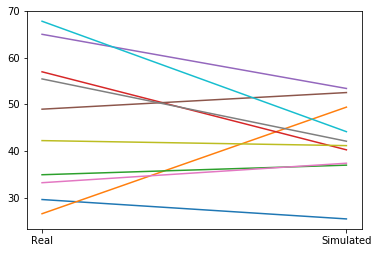

In [70]:
# connected jitterplot!

fig, ax = plt.subplots()

for real_dist, simulated_dist in zip([np.mean(v) for v in real_distances], [np.mean(v) for v in simulated_distances]):
    ax.plot([0,1], [real_dist, simulated_dist])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['Real', 'Simulated'])

In [73]:
ttest_rel([np.mean(v) for v in real_distances], [np.mean(v) for v in simulated_distances])

Ttest_relResult(statistic=0.9046541582523183, pvalue=0.3892228079899992)

# Part 2

Now we have a look into probability sampling

First we check if our probability sampling samples uniformly on a binary cellmask (as is expected)

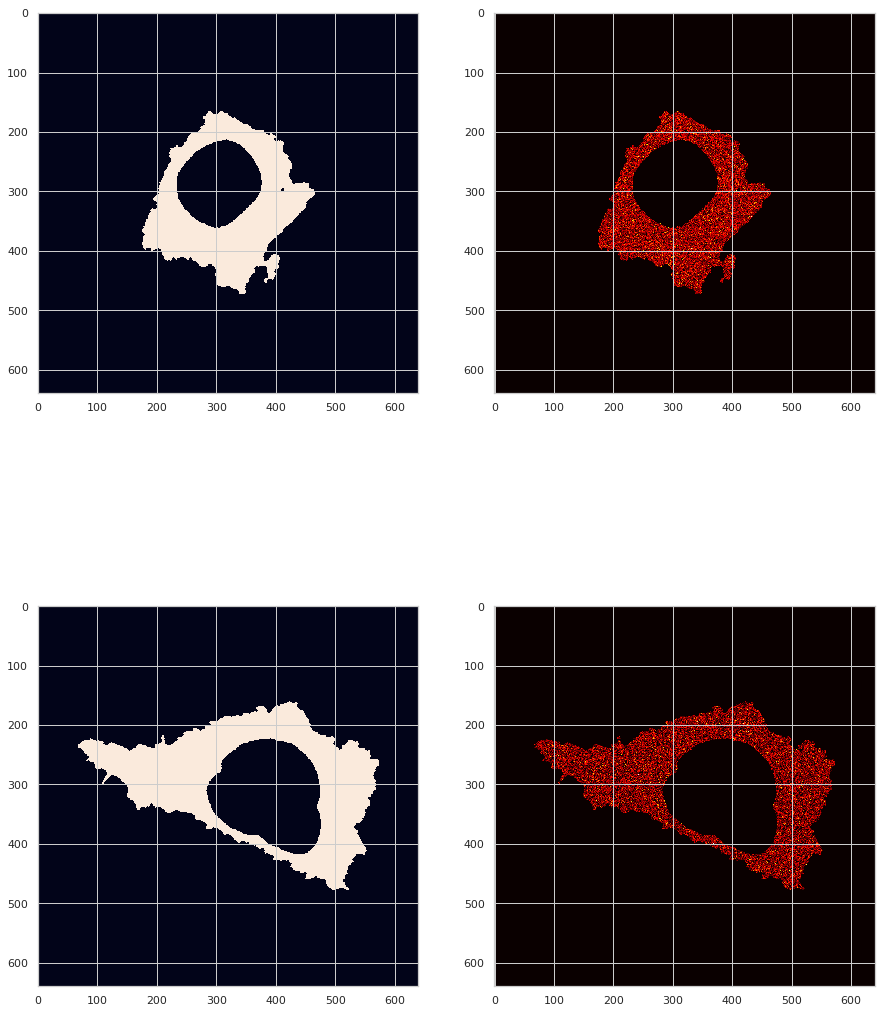

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=NUM_IMAGES, figsize=(15, 20))

real_distances = []
simulated_distances = []

for i in range(NUM_IMAGES):
    # read raw channels
    pbodies_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['pbodies']), 0)
    dapi_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['dapi']), 0)
    cellmask_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['cellmask']), 0)
        
    centroids = extract_centroids(pbodies_image)
    # plot the sample area
    cytoplasmic_mask = extract_sample_area(cellmask_image, dapi_image)
    axes[i, 0].imshow(cytoplasmic_mask)
    
    sampled_image = np.zeros(shape=cytoplasmic_mask.shape, dtype=np.uint32)
    
    for sample in sample_pbodies(cytoplasmic_mask, 100000):
        sampled_image[sample[1], sample[0]] += 1
        
    # normalize for 255
    axes[i, 1].imshow(sampled_image, cmap=plt.get_cmap('hot'))

using a probability map

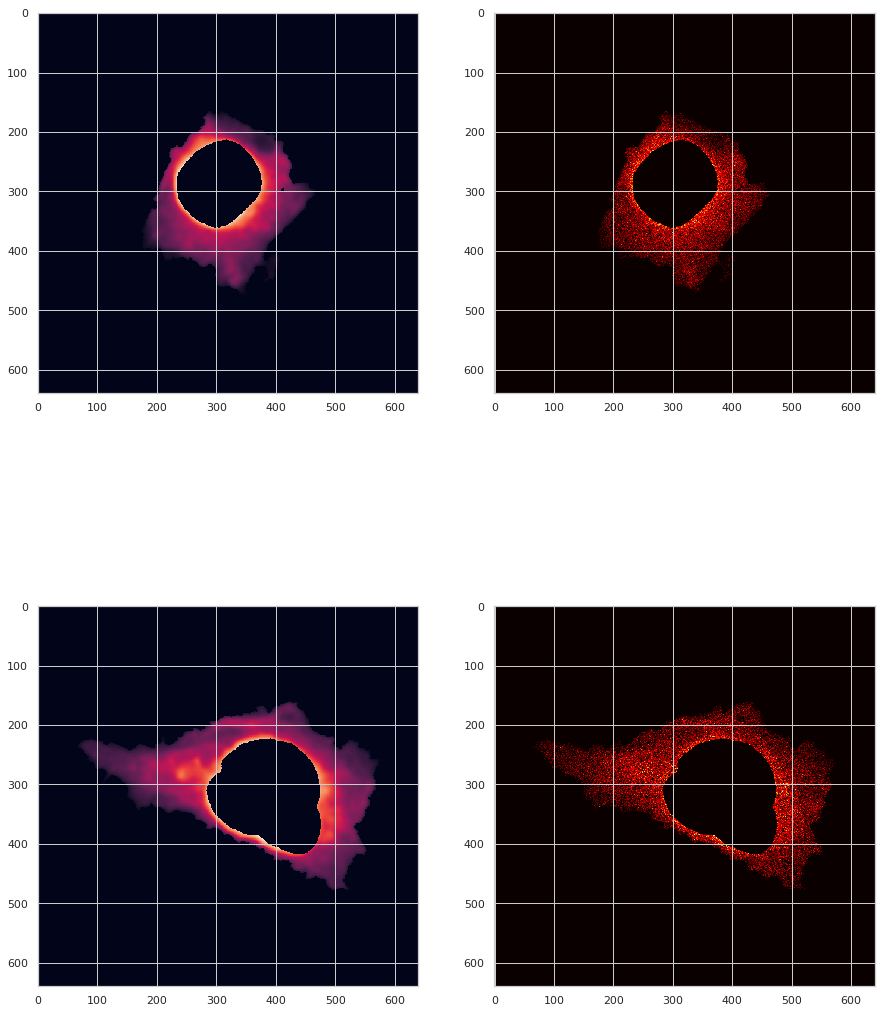

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=NUM_IMAGES, figsize=(15, 20))

real_distances = []
simulated_distances = []

for i in range(NUM_IMAGES):
    # read raw channels
    pbodies_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['pbodies']), 0)
    dapi_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['dapi']), 0)
    cellmask_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['cellmask']), 0)
    protein_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['protein']), 0)
    smooth = smooth_protein_image(protein_image, pbodies_image, extract_sample_area(cellmask_image, dapi_image))
    centroids = extract_centroids(pbodies_image)
    # plot the sample area
    cytoplasmic_mask = extract_sample_area(cellmask_image, dapi_image)
    axes[i, 0].imshow(smooth)
    
    sampled_image = np.zeros(shape=cytoplasmic_mask.shape, dtype=np.uint32)
    
    for sample in sample_pbodies(smooth, 100000):
        sampled_image[sample[1], sample[0]] += 1
        
    # normalize for 255
    axes[i, 1].imshow(sampled_image, cmap=plt.get_cmap('hot'))